In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Regression problem

Given dataset

$$
\{(x_i, y_i)\}_{i=0}^{N-1}
$$

where

$$
y_i = f(x_i)
$$

where $f(x)$ is the underlying function (ground truth / target function).

Regression problem is to find parameters $\theta$ from a model function $f_{\theta}(x)$ that minimize the following least square error:

$$
\min_{\theta} L(\theta) = \min_\theta \frac{1}{2N}\sum_{i=0}^{N-1} \left(f_{\theta}(x_i) - y_i \right)^2
$$

$$
\theta^{k+1} = \theta^k - t \nabla_{\theta}L(\theta^k)
$$

$$
\nabla_{\theta}L(\theta) = \frac{1}{N} \sum_{i=0}^{N-1} \left(f_{\theta}(x_i) - y_i \right) \nabla_{\theta}f_\theta(x_i)
$$

## Linear Regression

Model function:

$$
f_{\theta}(x) = wx + b
$$

$$
\theta = [w, b]
$$

In [3]:
def linear(w: float, b: float, x: np.ndarray):
    return w * x + b

def grad_w(x):
    return x

def grad_b(x):
    return 1.0

In [4]:
def gd_step(params: tuple[float] | list[float], t: float, x: np.ndarray, y: np.ndarray):
    wk, bk = params
    w = wk - t * np.mean((linear(wk, bk, x) - y) * grad_w(x))
    b = bk - t * np.mean((linear(wk, bk, x) - y) * grad_b(x))
    return w, b

In [43]:
def newton_step(params, t, x, y):
    wk, bk = params
    gw = np.mean((linear(wk, bk, x) - y) * grad_w(x))
    gb = np.mean((linear(wk, bk, x) - y) * grad_b(x))

    H = np.zeros((2, 2))
    H[0, 0] = np.mean(grad_w(x) * grad_w(x))
    H[0, 1] = np.mean(grad_w(x) * grad_b(x))
    H[1, 0] = np.mean(grad_b(x) * grad_w(x))
    H[1, 1] = np.mean(grad_b(x) * grad_b(x))
    
    # [gw, gb] shape: (2,)
    # np.dot(np.stack([gw, gb]), np.linalg.inv(H))
    dwb = np.stack([gw, gb]).dot(np.linalg.inv(H))
    
    return wk - t * dwb[0], bk - t * dwb[1]

# Runge function

Consider the function

$$
R(x) = \frac{1}{1+x^2}, \quad\quad x\in[-5,5]
$$

Let's plot the function first:

In [6]:
x = np.linspace(-5, 5, 100)

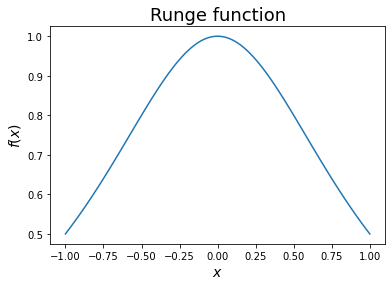

In [8]:
def R(x):
    return 1.0 / (1.0 + x**2)

fig, ax = plt.subplots()
ax.set_title("Runge function", fontsize=18)
ax.set_xlabel(r"$x$", fontsize=14)
ax.set_ylabel(r"$f(x)$", fontsize=14)
ax.plot(x, R(x))

In [79]:
def fit(x, y, init_params, init_t, eps=1e-4, max_steps=10000):
    params, t = init_params, init_t
    
    for step in range(max_steps):
        new_params = newton_step(params, t, x, y)
        diff = np.asarray(new_params) - np.asarray(params)
        if  np.sqrt(np.sum(diff**2)) < eps:
            return new_params, step
        else:
            params = new_params

    return new_params, step

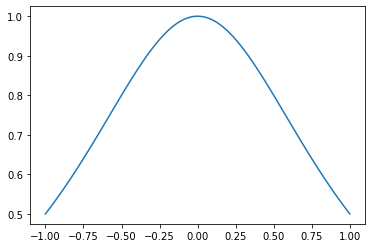

In [119]:
x = np.linspace(-1, 1, 100)
y = R(x)

plt.plot(x, y)

In [80]:
(w_m, b_m), num_steps = fit(x, y, [1.0, 1.0], 0.2)
num_steps

35

In [81]:
w_m, b_m

(-0.17339318356154257, 0.7116538785874036)

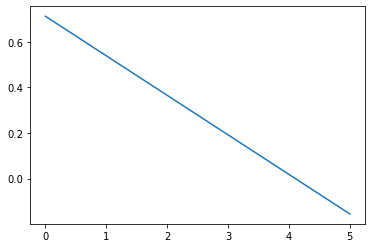

In [82]:
plt.plot(x, linear(w_m, b_m, x))

## General Polynomial fitting with GD

In [ ]:
def linear(params: np.ndarray, x: np.ndarray):
    return params[0] * x + params[1]

def quadratic(params: np.ndarray, x: np.ndarray):
    return params[0] * x**2 + params[1] * x + params[2]

# shape x: (N,), grad(x): (N, 2)
def grad_linear(x):
    grad = np.stack([x, np.ones_like(x)], axis=-1)
    return grad
        
# grad(x): (N, 3)
def grad_quad(x):
    grad = np.stack([x**2, x, np.ones_like(x)], axis=-1)
    return grad

def gd_step(params: np.ndarray, t: float, x: np.ndarray, y: np.ndarray):
    params -= t * np.mean((quadratic(params, x) - y)[..., None] * grad_quad(x), axis=0)
    return params

### Create general polynomial model and their grads

In [26]:
for i in reversed(range(1, 3)):
    print(i)

2
1


In [87]:
# Create a n-th order polynomial function
def create_poly_fn(n):
    def poly_fn(params, x):
        assert params.shape[0] == n + 1, f"Number of params should equal {n + 1}"
        value, power = 0.0, 1.0
        for i in range(n + 1):
            value += params[n-i] * power
            power *= x
        return value

    return poly_fn

def create_grad_poly_fn(n):
    def grad_poly_fn(x):
        stack_list = [x**(n-i) for i in range(n)] + [np.ones_like(x)]
        grad = np.stack(stack_list, axis=-1)
        return grad

    return grad_poly_fn


In [88]:
# For example, create 3th order polynomial function and its gradient function
n = 3
poly_fn = create_poly_fn(n)
grad_poly_fn = create_grad_poly_fn(n)

def gd_step(params: np.ndarray, t: float, x: np.ndarray, y: np.ndarray):
    params -= t * np.mean((poly_fn(params, x) - y)[..., None] * grad_poly_fn(x), axis=0)
    return params

In [89]:
def fit(x, y, init_params, init_t, eps=1e-4, max_steps=100000):
    params, t = init_params, init_t
    
    for step in range(max_steps):
        old_params = params.copy()
        params = gd_step(params, t, x, y)
        if  np.sqrt(np.sum((params - old_params)**2)) < eps:
            return params, step

    return params, step

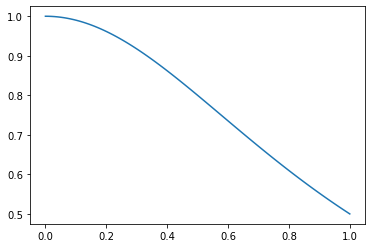

In [90]:
x = np.linspace(0, 1, 100)
y = R(x)

plt.plot(x, y)

In [93]:
params_min, num_steps = fit(x, y, np.array([0.1, 2.0, 1.0, 0.0]), 0.1)
params_min, num_steps

(array([-0.66772792,  0.70467926, -0.64499024,  1.03990645]), 2715)

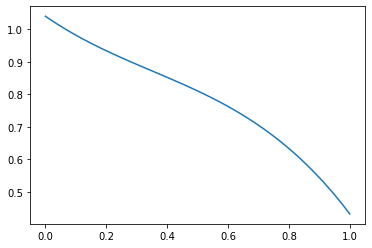

In [94]:
plt.plot(x, poly_fn(params_min, x))